# Classification models - supervised discretization

Dataset: pageblock <br>
By: Sam <br>
Update at: 22/03/2023 <br>

====

Summary:<br>
- Import unsupervised discretised datasets (already encoded categorical attributes)
- Split dataset: 75% training, 25% testing, seed = 30
- Class imbalance: Using SMOTE-Tomek for training data
- Perform 3 classification models: ChiMerge (4 settings) and Decision Tree (4 settings)
**For categorical Naive Bayes: passing number of categories of features in the parameter min_categories to avoid index out of bound error**
- Evaluation on testing data: Classification report (accuracy, precision, recall, f1-score) + G-mean
- Export models after training: CNB models - joblib; ID3 & Knn-Hamming: skops
- Write models performance to file: 'pageblock_supervised_disc_models.txt'.

### About Dataset
Number of Instances: 5473.

Number of Attributes: 10 numeric attributes
   - height: Height of the block.
   - lenght: Length of the block. 
   - area: Area of the block (height * lenght);
   - eccen: Eccentricity of the block (lenght / height);
   - p_black:Percentage of black pixels within the block (blackpix / area);
   - p_and: Percentage of black pixels after the application of the Run Length Smoothing Algorithm (RLSA) (blackand / area);
   - mean_tr: Mean number of white-black transitions (blackpix / wb_trans);
   - blackpix: Total number of black pixels in the original bitmap of the block.
   - blackand: Total number of black pixels in the bitmap of the block after the RLSA.
   - wb_trans: Number of white-black transitions in the original bitmap of the block.

class: the five classes are:
- text (1)
- horizontal line (2)
- picture (3)
- vertical line (4)
- graphic (5)

Missing Attribute Values:  No missing value.

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import set_option
import numpy as np
from numpy import arange
## EDA
from collections import Counter

In [2]:
# Pre-processing
from sklearn.preprocessing import OrdinalEncoder
# Cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score # 1 metric
from sklearn.model_selection import cross_validate # more than 1 metric
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
# For Naive Bayes
from sklearn.naive_bayes import CategoricalNB # Categorical Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Multinominal Naive Bayes (suitable for NLP)
from mixed_naive_bayes import MixedNB # Mixed Naive Bayes for combination of both discrete & continuous feature

In [4]:
# For decision tree ID3 
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from id3 import Id3Estimator # ID3 Decision Tree (https://pypi.org/project/decision-tree-id3/)
from id3 import export_graphviz

In [5]:
# Knn-VDM 3
from vdm3 import ValueDifferenceMetric
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# For model evaluation
from sklearn.metrics import classification_report
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ChiMerge data

## 1. Max intervals = 6

In [8]:
# Complete code for data preperation
# Read data
df_cm1 = pd.read_csv('sc_cm_pageblock_6int.csv')
df_cm1.rename(columns={'class':'label'}, inplace=True)

disc = 'CM'
k = 6

df_cm1.info()
data = df_cm1.values
data.shape

features = df_cm1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]
#X = df_cm1[features]
#Y = df_cm1['label']

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

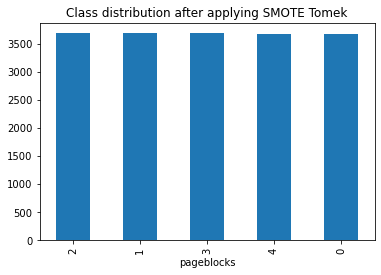

In [9]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models - CM, max intervals = 6

In [10]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 6'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
obj = sio.dump(model_id3, model_name)

In [11]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 6'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_CM_6.sav


['pageblock_CNB_CM_6.sav']

In [12]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 6'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_CM_6.skops


## 1.2 ChiMerge, max interval = 8

### Data prep

In [13]:
# Complete code for data preperation
# Read data
df_cm2 = pd.read_csv('sc_cm_pageblock_8int.csv')
df_cm2.rename(columns={'class':'label'}, inplace=True)
disc = 'CM'
k = 8

df_cm2.info()
data = df_cm2.values
data.shape

features = df_cm2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

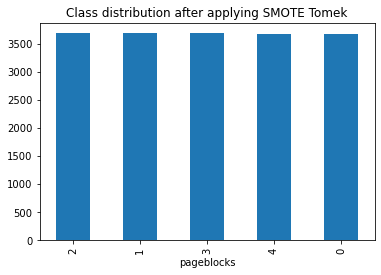

In [14]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models - ChiMerge, max intervals = 8

In [15]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 8'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_CM_8.skops


In [16]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 8'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_CM_8.sav


['pageblock_CNB_CM_8.sav']

In [17]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 8'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_CM_8.skops


## 1.3 ChiMerge, max intervals = 10

### Data prep

In [18]:
# Complete code for data preperation
# Read data
df_cm3 = pd.read_csv('sc_cm_pageblock_10int.csv')
df_cm3.rename(columns={'class':'label'}, inplace=True)
disc = 'cm'
k = 10

df_cm3.info()
data = df_cm3.values
data.shape

features = df_cm3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

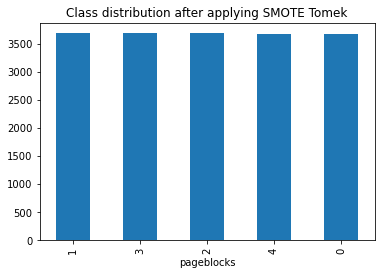

In [19]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models - ChiMerge, max intervals =10

In [20]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 10'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_CM_10.skops


In [21]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 10'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models

import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_CM_10.sav


['pageblock_CNB_CM_10.sav']

In [22]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 10'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_CM_10.skops


## 1.4 ChiMerge, max intervals = 15

### Data prep

In [23]:
# Complete code for data preperation
# Read data
df_cm4 = pd.read_csv('sc_cm_pageblock_15int.csv')
df_cm4.rename(columns={'class':'label'}, inplace=True)
disc = 'cm'
k = 15

df_cm4.info()
data = df_cm4.values
data.shape

features = df_cm4.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm4[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

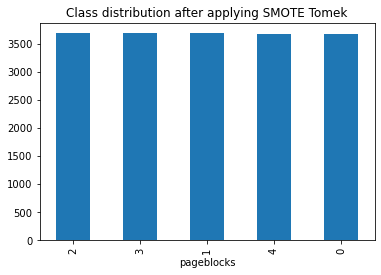

In [24]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models, ChiMerge, max intervals = 15

In [25]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 15'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_CM_15.skops


In [26]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 15'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models

import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_CM_15.sav


['pageblock_CNB_CM_15.sav']

In [27]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'CM'
disc_param = 'k = 15'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_CM_15.skops


# 2. Decision Tree Discretizer

## 2.1 DT, max_depth = 2

### Data prep

In [28]:
# Complete code for data preperation
# Read data
df_dt1 = pd.read_csv('DT_small_discretized_pageblock.csv')
df_dt1.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 2

df_dt1.info()
data = df_dt1.values
data.shape

features = df_dt1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

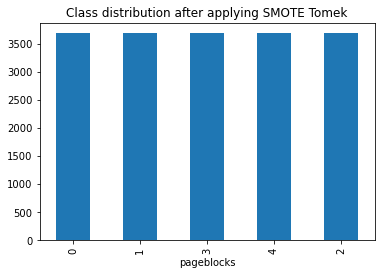

In [29]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models - DT, max_depth = 2

In [30]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 2'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_DT_2.skops


In [31]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 2'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_DT_2.sav


['pageblock_CNB_DT_2.sav']

In [32]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 2'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_DT_2.skops


## 2.2 Decision Tree, max_depth = 3

### Data prep

In [33]:
# Complete code for data preperation
# Read data
df_dt2 = pd.read_csv('DT_medium_discretized_pageblock.csv')
df_dt2.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 3

df_dt2.info()
data = df_dt2.values
data.shape

features = df_dt2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

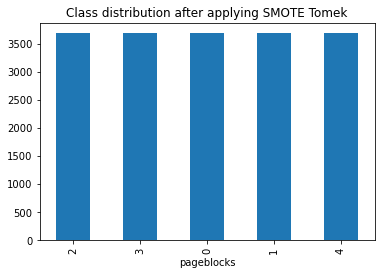

In [34]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models, DT, max_depth = 3

In [35]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 3'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_DT_3.skops


In [36]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 3'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_DT_3.sav


['pageblock_CNB_DT_3.sav']

In [37]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 3'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_DT_3.skops


## 2.3 Decision Tree, max_depth = 4

### Dataprep

In [38]:
# Complete code for data preperation
# Read data
df_dt3 = pd.read_csv('DT_large_discretized_pageblock.csv')
df_dt3.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 4

df_dt3.info()
data = df_dt3.values
data.shape

features = df_dt3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

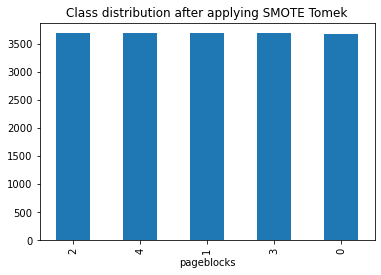

In [39]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models, DT, max_depth = 4

In [40]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 4'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_DT_4.skops


In [41]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 4'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_DT_4.sav


['pageblock_CNB_DT_4.sav']

In [42]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 4'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_DT_4.skops


## 2.3 Decision Tree, max_depth = 5

### Data prep

In [43]:
# Complete code for data preperation
# Read data
df_dt4 = pd.read_csv('DT_verylarge_discretized_pageblock.csv')
df_dt4.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 5

df_dt4.info()
data = df_dt4.values
data.shape

features = df_dt4.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt4[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   height    5473 non-null   int64
 1   length    5473 non-null   int64
 2   area      5473 non-null   int64
 3   eccen     5473 non-null   int64
 4   p_black   5473 non-null   int64
 5   p_and     5473 non-null   int64
 6   mean_tr   5473 non-null   int64
 7   blacpix   5473 non-null   int64
 8   blackand  5473 non-null   int64
 9   wb_trans  5473 non-null   int64
 10  label     5473 non-null   int64
dtypes: int64(11)
memory usage: 470.5 KB
(5473, 10) (5473,)
Class representation - original:  Counter({0: 4913, 1: 329, 4: 115, 3: 88, 2: 28})
Class representation - training data:  Counter({0: 3684, 1: 247, 4: 86, 3: 66, 2: 21})
Class representation - testing data:  Counter({0: 1229, 1: 82, 4: 29, 3: 22, 2: 7})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='pageblocks'>

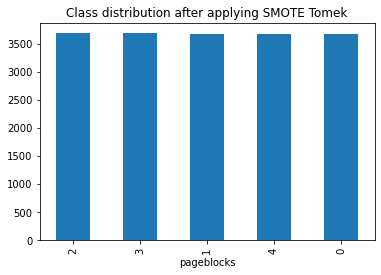

In [44]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='pageblocks')

### Models, DT, max_depth = 5

In [45]:
# ID3 - Default
model = 'ID3'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 5'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

pageblock_ID3_DT_5.skops


In [46]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 5'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

pageblock_CNB_DT_5.sav


['pageblock_CNB_DT_5.sav']

In [47]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'pageblock'
discretizer = 'DT'
disc_param = 'max_depth = 5'

f = open("pageblock_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

pageblock_KNN-Hamming_DT_5.skops
